# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by Simone Candeloro

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9911 / 11441 MB available


In [7]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];   
}
    
//NOTES: we need to implement the function matrixVectorKernel

__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols) {
    //NOTE: write for loop that computes the vector-vector inner product
    //      of row j of A by our vector b, then store the result in vector c[j]
    
    // i index is always zero! we don't need to compute it!       
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    float sum = 0.0f;
    
    for (int i = 0; i < a_cols; ++i){
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    // it's better to to this way rather than assigning directly "c[j] += A[k] * b[i]" because c[j] is in the global memory, thus it would be
    // very costly
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

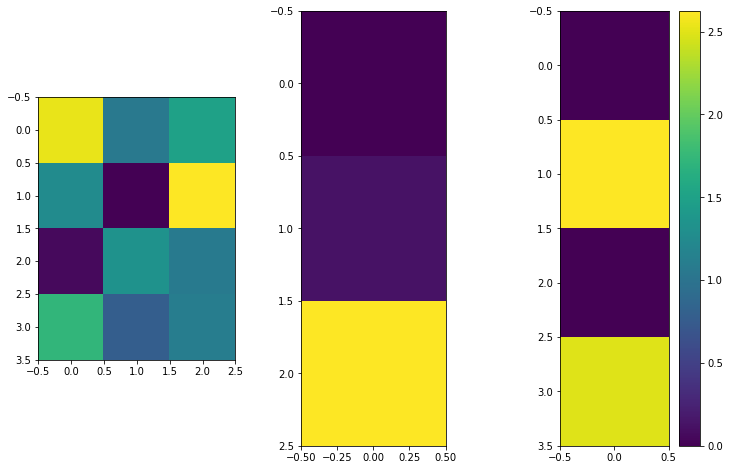

In [18]:
#Size of our test
test_size = (4, 3)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random((test_size[1],1)).astype(np.float32)
c = np.empty((test_size[0],1), dtype = np.float32)

fig = plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
plt.colorbar()
plt.show()

In [21]:
print(a.shape)
print(b.shape)
print(c.shape)

(4, 3)
(3, 1)
(4, 1)


In [22]:
#Upload data to the device
#NOTES: we need to make sure that a = (a_rows, a_columns), b = (a_columns, 1) [it's a column vector!], c = (a_rows, 1) [column vector too!]
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [23]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [24]:
# a.shape = [rows, columns] => [y index, x index]
domain_size = (a.shape[1], a.shape[0]) # Now domain size is [x, y]

#NOTES: we need to change this in order that grid*block is: x = 1, y = number of rows in A
block_size = (1, 1, 1) # These need to be x, y, z!
grid_size = (1, c.shape[0], 1)

print("Domain_size is " + str(domain_size))
print("Block_size is " + str(block_size))
print("Grid_size is " + str(grid_size))

Domain_size is (3, 4)
Block_size is (1, 1, 1)
Grid_size is (1, 4, 1)


In [25]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.47546875],
       [0.41928452],
       [0.25429553],
       [0.3445368 ]], dtype=float32)

In [26]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.47546875]
 [0.41928452]
 [0.25429553]
 [0.3445368 ]]
Ref =  [[0.47546878]
 [0.41928452]
 [0.25429553]
 [0.3445368 ]]
Sad =  2.9802322e-08


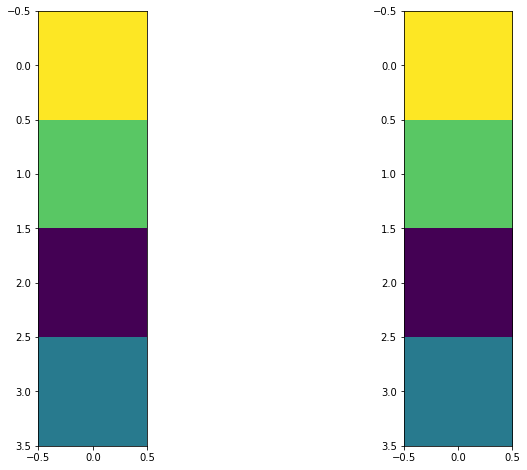

In [27]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)